In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import model_function

In [331]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
df.head()

C:\Users\crpdn\AppData\Local\Temp\ipykernel_14008\2964957048.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [332]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:400*10])
df.head()

,Pattern,Time,Current,On time,Off time
4000,81/1000,607.283088,1.197,70,120
4001,81/1000,607.472571,1.119,70,120
4002,81/1000,607.660899,1.075,70,120
4003,81/1000,607.852867,1.041,70,120
4004,81/1000,608.044976,1.012,70,120


In [333]:
target_points = 50
cutoff_current_min = 0.5

Text(0.5, 1.0, 'Data to be modeled')

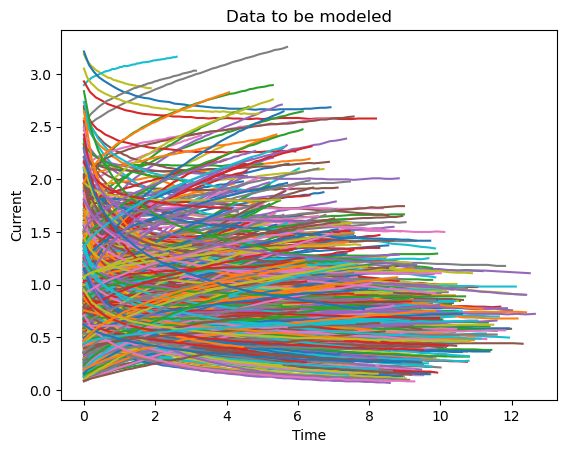

In [334]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
list_of_dfs_fixed = []
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != target_points:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == target_points
    if np.max(y_current)>cutoff_current_min:
        plt.plot(x_time, y_current, '-')
        list_of_dfs_fixed.append(data)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [335]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs_fixed),4))
#initialize array of expected shape
y_data = np.zeros((len(list_of_dfs_fixed), points, 2))

for i in range(len(list_of_dfs_fixed)):
    data = list_of_dfs_fixed[i]
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != target_points:
          print(points)
          continue
    if np.max(y_current)>cutoff_current_min:
          label = np.column_stack((x_time,y_current))  
          y_data[i,:,:]= label
          features =  np.array([4, np.min(y_current.values), data['On time'].iloc[0], data['Off time'].iloc[0]])
          X_data[i,:] = features

print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")


X shape:(762, 4)
y shape:(762, 50, 2)


In [336]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, train_size=0.3)

In [337]:
import keras

import tensorflow.keras.backend as K

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the specified task.

    Parameters:
    - y_true: Ground truth values, of shape (batch_size, 2, N).
    - y_pred: Predicted values, of shape (batch_size, 7,N).

    Returns:
    - loss: Scalar value representing the mean loss over the batch.
    """

    # Extract x and y values from y_true
    x_values = y_true[:,:,0]  # Shape: (batch_size, N)
    y_values = y_true[:,:,1]  # Shape: (batch_size, N)
    
    # print(x_values)
    # Apply the function to each element of y_pred based on the corresponding x_value
    # Result shape: (batch_size, N)
    # function_values = (
    #     y_pred[:, 0, :] * K.exp(-(x_values + y_pred[:, 1, :]) / y_pred[:, 2, :]) +
    #     y_pred[:, 3, :] * K.exp(-(x_values + y_pred[:, 4, :]) / y_pred[:, 5, :]) +
    #     y_pred[:, 6, :]
    # )
    function_values = (
        y_pred[:, :,0] * K.exp(-(x_values ) * y_pred[:, :,1]) +
        y_pred[:, :,2] * K.exp(-(x_values ) * y_pred[:, :,3]) +
        y_pred[:, :,4]
    )
    # Compute the difference between the function values and y_values
    # Result shape: (batch_size, N)
    diff = (y_values -function_values) #/ K.maximum(y_values, y_values+0.001)
    #diff = diff /100
    # print(diff)
    # Take the square of the differences
    squared_diff = K.square(diff)

    # Take the mean over the batch
    # Result shape: (batch_size,)
    #loss = K.sum(K.abs(diff), axis=-1)
    loss = K.sum(squared_diff, axis=-1)
    return loss
 

def create_nn():
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    layers_dense = keras.layers.Dense(10, 'relu')(inputs)
    layers_dense2 = keras.layers.Dense(10, 'relu')(layers_dense)
    layers_dense3 = keras.layers.Dense(10, 'relu')(layers_dense2)
    #layers_dense4 = keras.layers.Dense(100, 'relu')(layers_dense3)
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    parameters = keras.layers.Dense(5)(layers_dense3)
    # Expand parameters to have same shape as y_true
    expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=expanded_parameters, name="current_function_prediction")

In [338]:

# import numpy as np
# import matplotlib.pyplot as plt
# x = np.linspace(0,100, points)
# A1 = 1
# A2= 1
# t1 = 5
# t2= 3

# j0 = 2
# input_parameters = np.array((A1,t1,A2,t2,j0))
# y_pred = np.tile(input_parameters, (1, points, 1))
# #y_pred = np.reshape(y_pred,(1, 7, points))
# #print(y_pred)

# y = model_function.double_exponential_function(x, input_parameters)
# print(f'y = {y}')
# y_true = np.column_stack((x,y))
# #y_true = np.reshape(y_true, (2,points))
# y_true = np.expand_dims(y_true, axis=0)
# print(y_true.shape)


# print(K.eval(custom_loss(K.variable(y_true), K.variable(y_pred))).sum())



In [339]:
load = True

if load:
    model = keras.models.load_model('models/2023-12-15_15-30-46_RMSE_params_325_points_50.keras', custom_objects={'custom_loss':custom_loss})
else:
    model = create_nn()

model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 10)                50        
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 5)                 55        
                                                                 
 repeat_vector_2 (RepeatVec  (None, 50, 5)             0         
 tor)                                                            
                                       

In [340]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer=sgd, #'adam'
                  loss=custom_loss)

number_of_epochs = 300
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.8, 
                              patience=20, 
                              min_lr=1e-4)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    #plt.ylim(0,20)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [341]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                            #    ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/300


54/54 - 1s - loss: 10.0241 - val_loss: 10.9693 - 962ms/epoch - 18ms/step
Epoch 2/300
54/54 - 0s - loss: 9.4556 - val_loss: 10.2801 - 88ms/epoch - 2ms/step
Epoch 3/300
54/54 - 0s - loss: 9.3763 - val_loss: 9.8327 - 87ms/epoch - 2ms/step
Epoch 4/300
54/54 - 0s - loss: 9.1928 - val_loss: 10.2203 - 80ms/epoch - 1ms/step
Epoch 5/300
54/54 - 0s - loss: 9.0071 - val_loss: 9.6714 - 81ms/epoch - 1ms/step
Epoch 6/300
54/54 - 0s - loss: 8.9127 - val_loss: 9.3440 - 82ms/epoch - 2ms/step
Epoch 7/300
54/54 - 0s - loss: 8.7396 - val_loss: 10.7065 - 81ms/epoch - 2ms/step
Epoch 8/300
54/54 - 0s - loss: 8.5444 - val_loss: 9.2885 - 83ms/epoch - 2ms/step
Epoch 9/300
54/54 - 0s - loss: 8.7340 - val_loss: 9.3295 - 82ms/epoch - 2ms/step
Epoch 10/300
54/54 - 0s - loss: 8.4066 - val_loss: 9.0664 - 82ms/epoch - 2ms/step
Epoch 11/300
54/54 - 0s - loss: 8.7182 - val_loss: 11.1644 - 80ms/epoch - 1ms/step
Epoch 12/300
54/54 - 0s - loss: 8.5586 - val_loss: 9.1826 - 82ms/epoch - 2ms/step
Epoch 13/300
54/54 - 0s - los

In [342]:
# Save the model
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# model.save('models/'+filename)

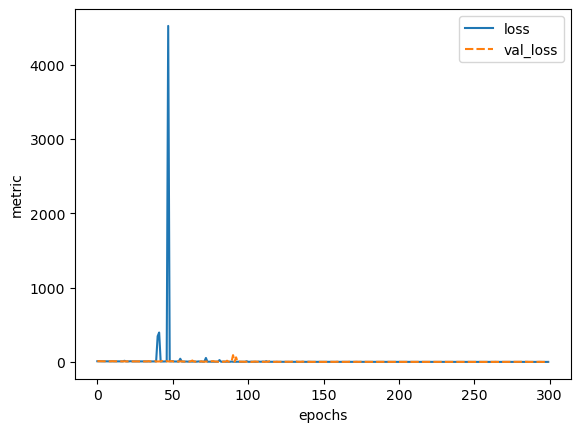

In [343]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'])

In [344]:
# make prediction on test data
y_train_prediction = model.predict(X_train)

17/17 [==============================] - 0s 790us/step


17/17 [==============================] - 0s 875us/step


Text(0.5, 1.0, 'Absolute Error of training data prediction')

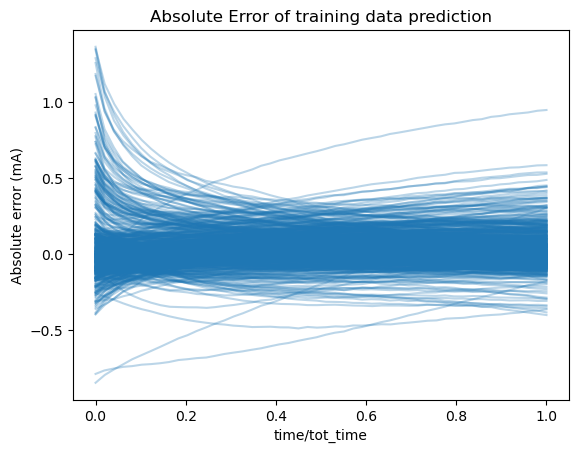

In [345]:
y_train_prediction = model.predict(X_train)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
for test_entry_index in range(X_train.shape[0]):
    # c = next(color)
    y_true = y_train[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), (y_true[:,1]- model_function.double_exponential_function(y_true[:,0], param_predicted)), '-', color = 'C0', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of training data prediction')

6/6 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Absolute Error of test data prediction')

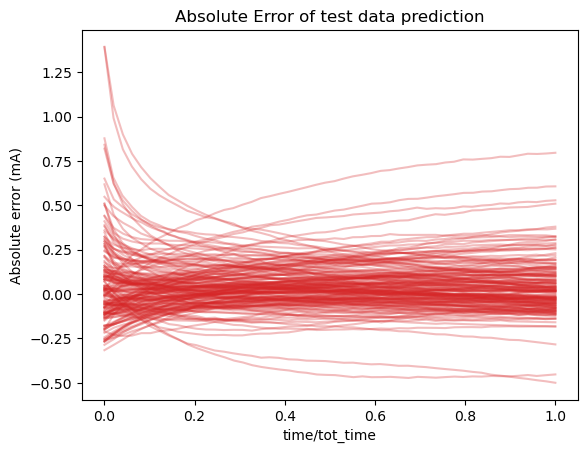

In [350]:
y_test_prediction = model.predict(X_test)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
for test_entry_index in range(X_test.shape[0]):
    # c = next(color)
    y_true = y_test[test_entry_index,:,:]
    param_predicted = y_test_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0]/np.max(y_true), (y_true[:,1]- model_function.double_exponential_function(y_true[:,0], param_predicted)), '-', color = 'C3', alpha = 0.3, )
    # plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.7)
    # plt.plot(y_true[:,0], model_function.double_exponential_function(y_true[:,0], param_predicted), '-', color = 'C1')
#plt.legend()
plt.xlabel('time/tot_time')
plt.ylabel('Absolute error (mA)')
plt.title('Absolute Error of test data prediction')